# Get started with `gappyfpca`

### Load modules
- From gappyfpca load gappyfpca to generate the fpca decompostion and reconstruct_func to reconstruct the functions from the decomposition
- Numpy is required to generate synthetic data in a np.array format, and matplotlib to plot the results

In [1]:
from gappyfpca.fpca import *
from gappyfpca.eig import fpca_num_coefs
import numpy as np
import matplotlib.pyplot as plt

### Generate some synthetic data

- For gappyfpca the data must be saved in a np.ndarray of size M x L where M (rows) is the number of data functions and L (cols) is the length of each function. 
- Each function must be discretised to the same grid, and missing data is indicated with NaN
- This example plots 3-order polynomials, therefore the exact functions should be returned with 3 PC components for full functions

In [2]:
# generate synthetic dataset to test

# Parameters
M = 1000  # Number of functions
L = 50   # Length of each function


# Random polynomials
nsize=3
functions = np.array([np.polyval(np.random.uniform(-1, 1, size=nsize), np.linspace(-1, 1, L)) 
                      for _ in range(M)])

data=np.copy(functions)
#artifically gappy it
for i in range(M):
    # Determine the number of NaNs to insert (0 to <25% of the function length)
    num_nans = np.random.randint(0, L // 2)  
    # Randomly select indices to replace with NaN
    nan_indices = np.random.choice(L, num_nans, replace=False)
    # Replace selected indices with NaN
    data[i, nan_indices] = np.nan



### Check gappy data suitability
- `check_gappiness()` will check whether the data is suitable for the fPCA algorithm and it's recommended that you call it before running `gappyfpca()`
    - Rows or columns with all NaNs: clean_empty_data() will remove any rows or columns which are entirely empty. 
    - Dot of data has NaNs: currently, there is no function provided to handle this, this will need to be done by the user. There must be no two functions which do not have any overlapping data and the problem row/column combinations will be indicted
    - Data is suitable: total percentage of missing data printed
- If the data is 'too gappy' the result will not be able to converge to the desired tolerance - consider removing some of the gappiness ie. remove functions (rows) or grid points (columns) with the highest percentage of gappiness or relaxing the constraint, depending on the usecase

- A hard limit to ensure calculation is that each function must be more than 50% complete, but in practice they can be much more gappy

In [3]:
check_gappiness(data)

Data is suitable for gappy fPCA method with 24.24% missing data.


### Find fPCA representation

- call `gappyfpca()` to compute the fPCA representation
- Required inputs are
    - data matrix
    - explained variance of components (N) to return, the convergence will be tested at this value
- Optional inputs are 
    - max_iter, the absolute max number of iterations, default = 25
    - stable_iter, the number of iterations that the reconstruction must be stable for, default = 5
    - tol, convergence tolerance for reconstructed functions, default = 5e-3
    - iparallel, default = 0, if iparallel = 1, Multiprocessing is called for the calculation of the weight optimisation to speed up computation
- The outputs are:
    - fpca_comps, N+1 x L, where the first row is the data mean and N is the number of components
    - fpca_coefs, M x N
    - eigenvalues for full decompostion, size = min(L,M)
    - run_stat: array of reconstruction change error at each iteration
- Considerations:  
    - Setting explained variance at 0.95 ensures noisy PCs due to missing data are not returned

In [4]:
# Generate fpca of gappy data using
fpca_comps,fpca_coefs,evalue,run_stat=gappyfpca(data,exp_var=0.95,max_iter=15,stable_iter=5,tol=5e-3,iparallel=0)

Gappy Functional PCA: Starting Analysis
Time for initial step: 7.90 seconds

Entering iterative loop...

--- Iteration 1/15 ---
     Relative reconstruction is above tolerance: 5.15e-02
     Iteration time: 7.747 seconds
--- Iteration 2/15 ---
     Relative reconstruction is above tolerance: 6.50e-03
     Iteration time: 7.762 seconds
--- Iteration 3/15 ---
     Relative reconstruction is below tolerance: 2.17e-03 | Stable count: 1/5
     Iteration time: 7.946 seconds
--- Iteration 4/15 ---
     Relative reconstruction is below tolerance: 1.50e-03 | Stable count: 2/5
     Iteration time: 7.779 seconds
--- Iteration 5/15 ---
     Relative reconstruction is below tolerance: 1.32e-03 | Stable count: 3/5
     Iteration time: 8.643 seconds
--- Iteration 6/15 ---
     Relative reconstruction is below tolerance: 1.44e-03 | Stable count: 4/5
     Iteration time: 7.739 seconds
--- Iteration 7/15 ---
     Relative reconstruction is below tolerance: 1.35e-03 | Stable count: 5/5
     Iteration tim

#### fPCA on non-gappy data for comparison
- max 1 iteration as solution will already be converged

In [5]:
# perform fPCA on non gappy data to compare (1 iteration)
fpca_comps_full, fpca_coefs_full, _, _ = gappyfpca(functions,exp_var=1,max_iter=1)

Gappy Functional PCA: Starting Analysis
Time for initial step: 0.57 seconds

Entering iterative loop...

--- Iteration 1/1 ---
     Relative reconstruction is below tolerance: 3.23e-15 | Stable count: 1/4
     Iteration time: 0.442 seconds
Gappy fPCA Computation Finished
3 coefficients retained for 100 % explained variance
Total iterations: 1/1
Stable iterations: 1/4
Final relative reconstruction change: 3.23e-15
Total computation time: 1.01 seconds


### Plot fPCA mean and modes of gappy vs full representation


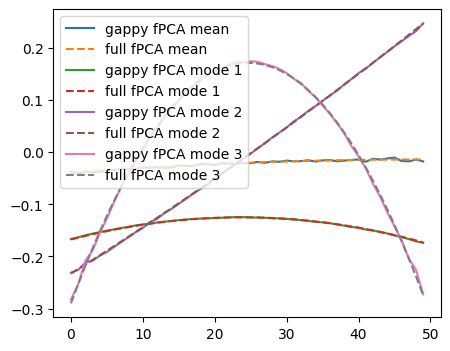

In [6]:
# plot the modes vs non-gappy modes
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.plot(fpca_comps[0,:],label='gappy fPCA mean')
ax.plot(fpca_comps_full[0,:],'--',label='full fPCA mean')
modes_to_plot = min(5,fpca_comps_full.shape[0])
for i in range(1,modes_to_plot):
    ax.plot(fpca_comps[i,:],label='gappy fPCA mode '+str(i))
    ax.plot(fpca_comps_full[i,:],'--',label='full fPCA mode '+str(i))
ax.legend()

Text(0, 0.5, 'Coefficient value')

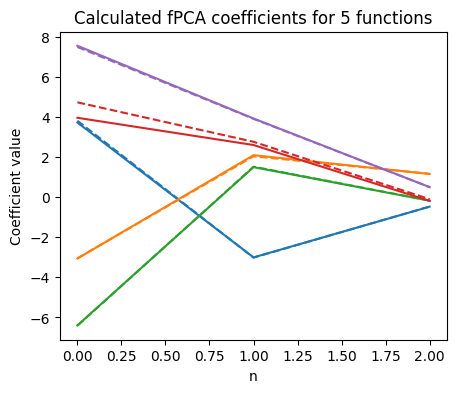

In [7]:
# plot the coefficients
colors = plt.cm.tab10.colors
fig,ax=plt.subplots(1,1,figsize=(5,4))
modes_to_plot = min(5,fpca_coefs_full.shape[0])
for i in range(5):
    ax.plot(fpca_coefs[i,:nsize+1],color=colors[i])
    ax.plot(fpca_coefs_full[i,:nsize+1],'--',color=colors[i])

ax.set_title('Calculated fPCA coefficients for 5 functions')
ax.set_xlabel('n')
ax.set_ylabel('Coefficient value')


### Reconstruct data

- call `reconstruct_func()`
- Inputs are fpca_mean (L), fpca_comps (N x L) , fpca_coefs (M x N)
- Returns an array of the reconstructed functions, size M x L

In [19]:
# Impute missing data at 95% explained variance, excludes noise due to missing data

# find number of coefficients
num_coefs=fpca_num_coefs(evalue,0.95)
print(num_coefs,' coefficients explain 95% of variance')

function_recon=reconstruct_func(fpca_comps[0,:],fpca_comps[1:,:],fpca_coefs,num_coefs)
full_function_recon=reconstruct_func(fpca_comps_full[0,:],fpca_comps_full[1:,:],fpca_coefs_full,num_coefs=num_coefs)


3  coefficients explain 95% of variance


### Plot raw data (solid) vs gappy fpca reconstruction (dashed) vs full fpca reconstruction (dotted)

Text(0.5, 1.0, '5 Reconstructed functions')

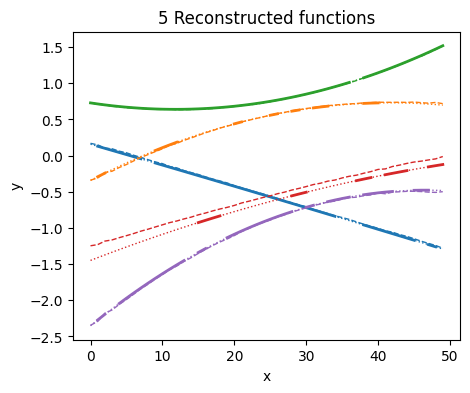

In [20]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
colors = plt.cm.tab10.colors
for i in range(5):
    ax.plot(data[i,:],linestyle='-',linewidth=2,color=colors[i])
    ax.plot(function_recon[i,:],linestyle='--',linewidth=1,color=colors[i])
    ax.plot(full_function_recon[i,:],linestyle=':',linewidth=1,color=colors[i])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('5 Reconstructed functions')

- a 'good' reconstruction should be seen for the functions !
    - offset between reconstruction and data can be seen when data is missing on one end of function, leads to a bias in the fit of the coefficients to the gappy data, despite returned components and mean being very close to the full data representation